In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()

## MOCA2

In [3]:
def find_root(x, y, degree=3):
    """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
    coeffs = np.polyfit(x, y, degree)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid_x = x[len(x) // 2]
    return real_roots[np.argmin(np.abs(real_roots - mid_x))]

def tangent_at_root(x, y, root_x, degree=3):
    coeffs = np.polyfit(x, y, degree)
    slope = np.polyval(np.polyder(coeffs), root_x)
    intercept = np.polyval(coeffs, root_x) - slope * root_x
    y_fit = np.polyval(coeffs, x)
    r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
    return slope, intercept, r2

def moca2(nic, njc, r, u, v, X, Y):

    # Vertical profile along column njc
    u1 = u[nic - r: nic + r + 1, njc]
    v1 = v[nic - r: nic + r + 1, njc]
    x1 = X.T[nic - r: nic + r + 1, njc]
    y1 = Y.T[nic - r: nic + r + 1, njc]
    center_x = X.T[nic, njc]
    xx = x1 - center_x

    # Horizontal profile along row nic
    u2 = u[nic, njc - r: njc + r + 1]
    v2 = v[nic, njc - r: njc + r + 1]
    x2 = X.T[nic, njc - r: njc + r + 1]
    y2 = Y.T[nic, njc - r: njc + r + 1]
    center_y = Y.T[nic, njc]
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    return x0 + center_x, y0 + center_y, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy


In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

In [5]:
df_tests['x']= x[df_tests['nic']]
df_tests['y']= y[df_tests['njc']]
df_tests

,nic,njc,r,x,y
P1,53,53,5,15.0,15.0
P2,42,58,5,-40.0,40.0
P3,39,39,5,-55.0,-55.0
L1,53,53,3,15.0,15.0
L2,53,53,5,15.0,15.0
L3,53,53,7,15.0,15.0


-0.019724209306378526 -0.019724209306378526
-4.039353864131108 4.0393538641316695
-12.867740705537457 -12.867740705537457


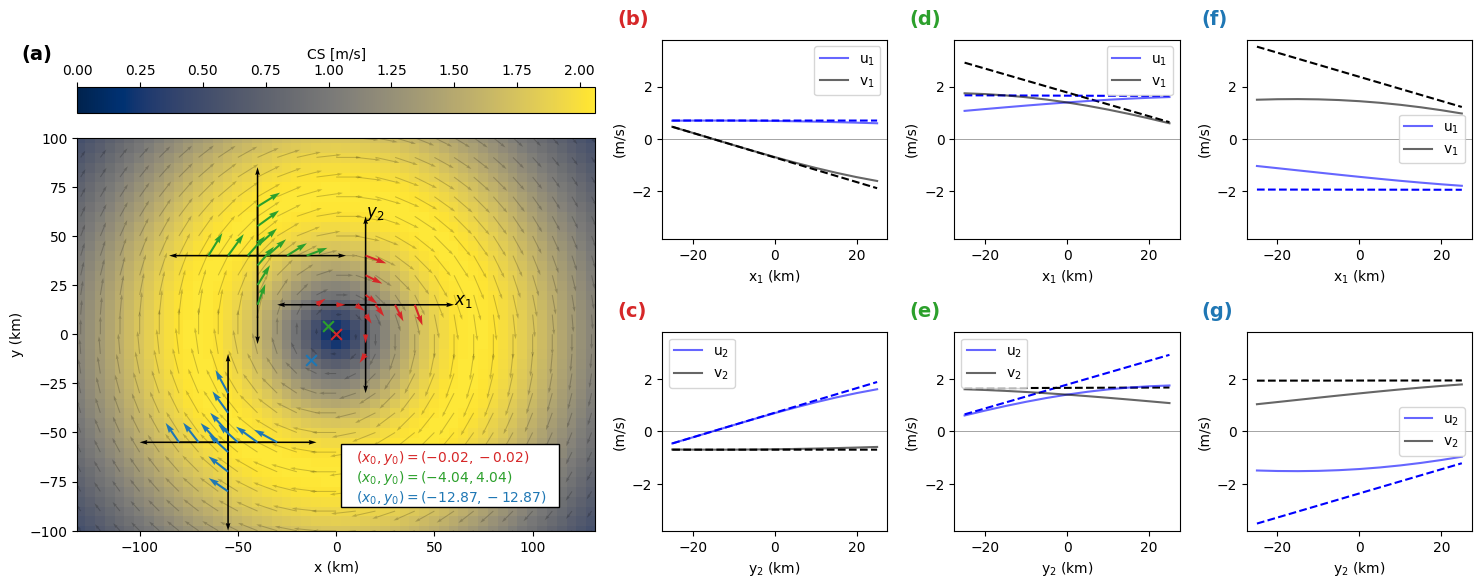

In [6]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i])
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

0.007482736633351195 0.007482736633351195
-0.019724209306378526 -0.019724209306378526
-0.04800732223571913 -0.04800732223571913


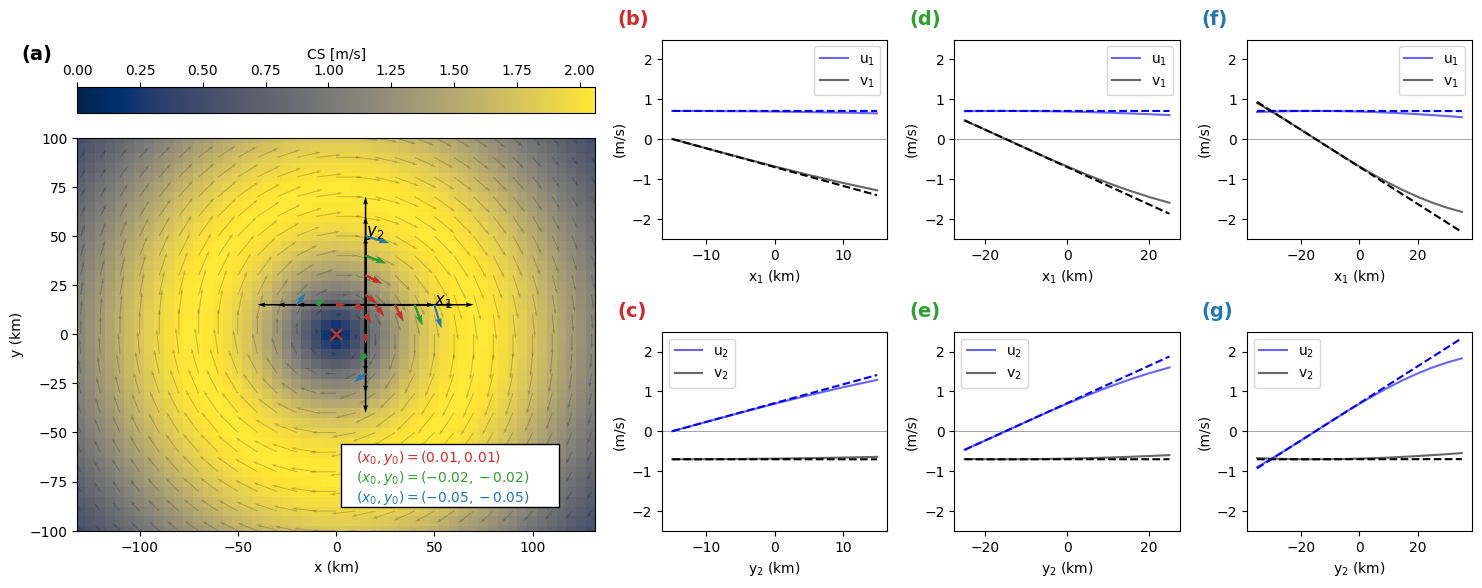

In [7]:
fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [8]:
df = pd.DataFrame(columns=['x0', 'y0'])
for dic in dic_tests.values():
    df.loc[len(df)] = {'x0': dic['x0'], 'y0': dic['y0']}
df.index = dic_tests.keys()

df

,x0,y0
P1,-0.019724,-0.019724
P2,-4.039354,4.039354
P3,-12.867741,-12.867741
L1,0.007483,0.007483
L2,-0.019724,-0.019724
L3,-0.048007,-0.048007


# Elliptical Vortex with Modifications


In [9]:
u, v, _, _ = calculate_eddy(q11=2, q22=2, q12=1)

In [10]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }



0.013369631894477152 0.013369631894477152
-0.7547360744246916 0.7547360744247413
-18.68764509995333 -18.68764509995333


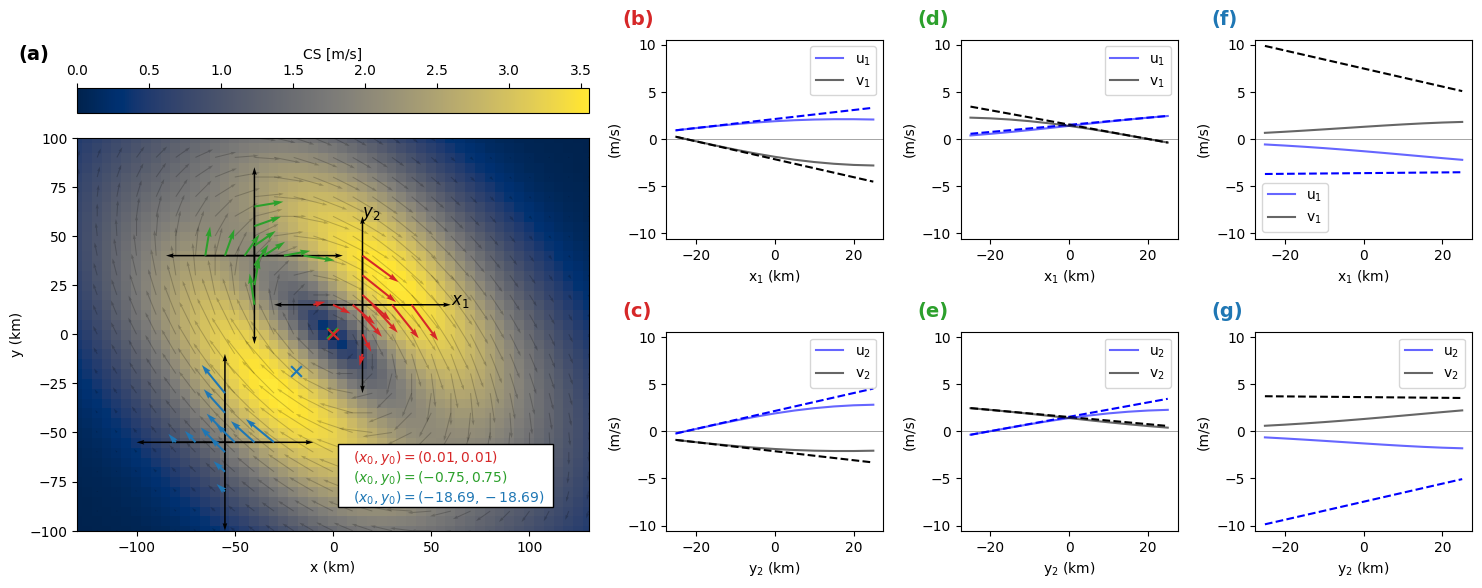

In [11]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

0.17739536970799286 0.17739536970799286
0.013369631894477152 0.013369631894477152
-0.17663705389286655 -0.17663705389286655


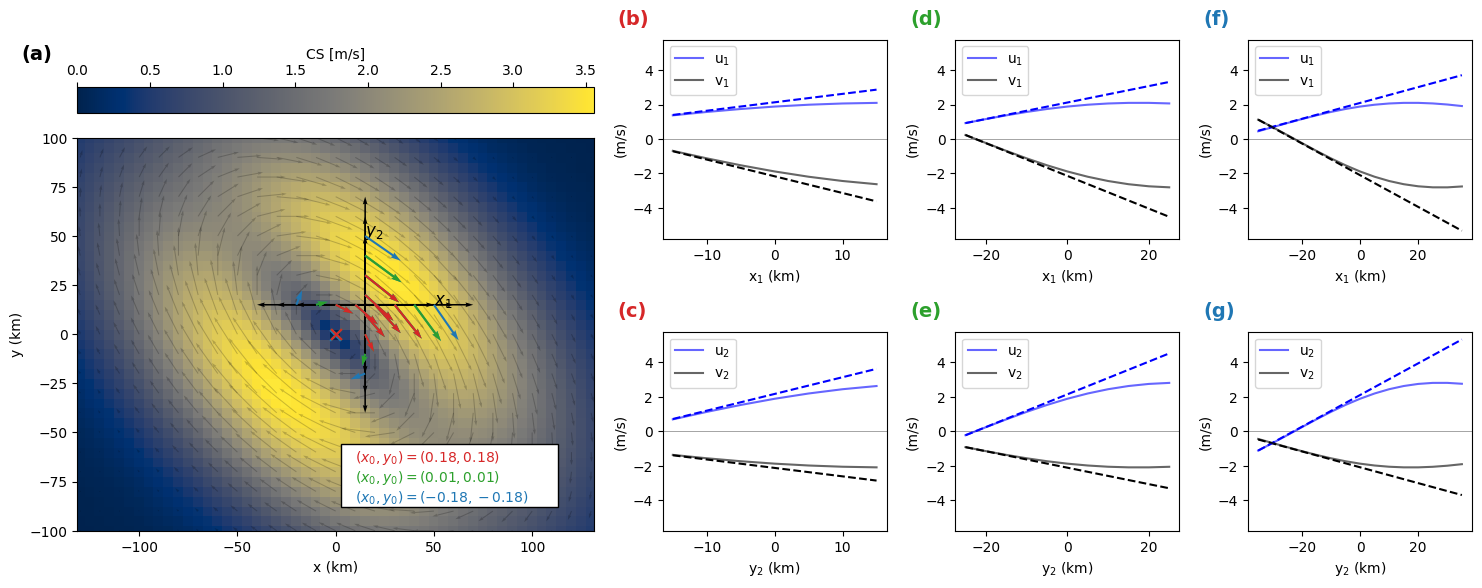

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(f)','(g)'), ('(d)','(e)')]
for dic in dic_tests.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0, _ = tangent_at_root(xx, u1, root_x)
        B1, B0, _ = tangent_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0, _ = tangent_at_root(yy, u2, root_y)
        D1, D0, _ = tangent_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## Intense r Optimal Finder Analysis

In [13]:
X, Y = np.meshgrid(x, y)
df_r_tests = pd.DataFrame(columns=['i', 'j', 'x0', 'y0', 'w', 'Err', 'r'])
boundary = 20

for nic_rel in range(boundary, u.shape[0] - boundary):
    for njc_rel in range(boundary, u.shape[1] - boundary):

        df = pd.DataFrame(columns=['i', 'j', 'x0', 'y0', 'w', 'Err', 'r'])
        for r_rel in range(2, 11):
            x0_rel, y0_rel, w_rel, *_ = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
            error_rel = np.hypot(x0_rel, y0_rel)
            df.loc[len(df)] = {'i': nic_rel, 'j': njc_rel, 'x0': x0_rel, 'y0': y0_rel, 
                               'w': w_rel, 'Err': error_rel, 'r': r_rel}

        # if not df.empty:
        df_r_tests.loc[len(df_r_tests)] = df.loc[df['Err'].idxmin()]

df_r_tests

,i,j,x0,y0,w,Err,r
0,20.0,20.0,-148.570159,-148.570159,0.000006,210.109934,10.0
1,20.0,21.0,-146.304126,-147.879695,0.000007,208.022358,10.0
2,20.0,22.0,-149.063314,-143.796068,0.000006,207.116346,10.0
3,20.0,23.0,-153.573568,-153.136931,0.000010,216.877293,2.0
4,20.0,24.0,-153.724171,-148.517807,0.000014,213.749057,2.0
...,...,...,...,...,...,...,...
3716,80.0,76.0,153.724171,148.517807,0.000014,213.749057,2.0
3717,80.0,77.0,153.573568,153.136931,0.000010,216.877293,2.0
3718,80.0,78.0,149.063314,143.796068,0.000006,207.116346,10.0
3719,80.0,79.0,146.304126,147.879695,0.000007,208.022358,10.0


/scratch/pbs.6294132.kman.restech.unsw.edu.au/ipykernel_735432/1856923900.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Error (km)')


Text(0, 0.5, 'y (km)')

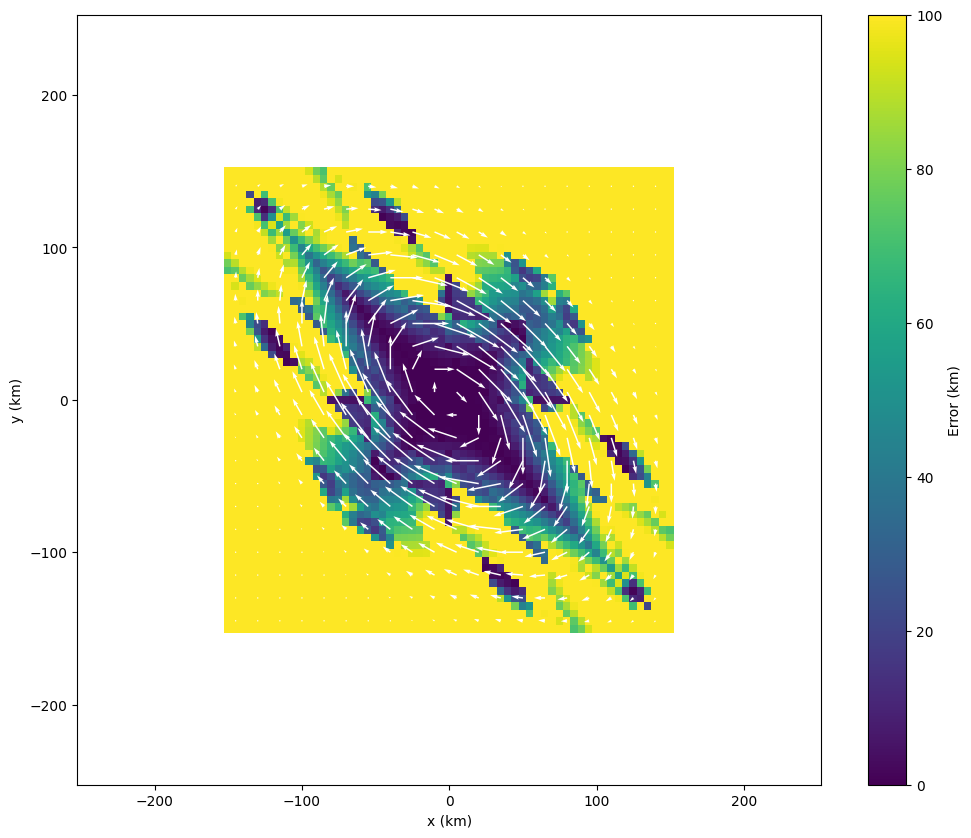

In [14]:
E = np.full_like(u, np.nan)

i_vals = df_r_tests['i'].astype(int).to_numpy()
j_vals = df_r_tests['j'].astype(int).to_numpy()
err_vals = df_r_tests['Err'].to_numpy()

E[i_vals, j_vals] = err_vals

fig = plt.figure(figsize=(12,10))

plt.pcolor(X, Y, E.T, vmin=0, vmax=100)
plt.colorbar(label='Error (km)')
spacing = 3
plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=1, scale=50, width=width, color='w')

plt.xlabel('x (km)')
plt.ylabel('y (km)')

/scratch/pbs.6294132.kman.restech.unsw.edu.au/ipykernel_735432/2950587468.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Search Radius r (km)')


Text(0, 0.5, 'y (km)')

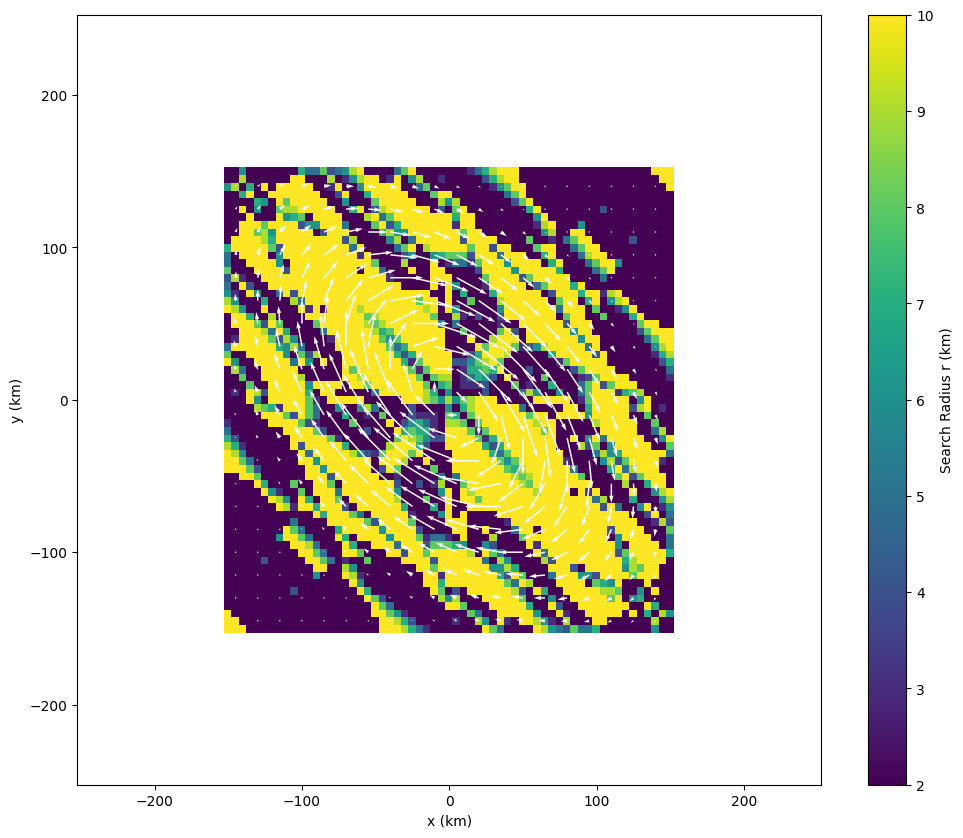

In [15]:
R = np.full_like(u, np.nan)

i_vals = df_r_tests['i'].astype(int).to_numpy()
j_vals = df_r_tests['j'].astype(int).to_numpy()
r_vals = df_r_tests['r'].to_numpy()

R[i_vals, j_vals] = r_vals

fig = plt.figure(figsize=(12,10))

plt.pcolor(X, Y, R.T)
plt.colorbar(label='Search Radius r (km)')
spacing = 3
plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=1, scale=50, width=width, color='w')
plt.xlabel('x (km)')
plt.ylabel('y (km)')

## Error Map

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
%%capture

df_error = pd.DataFrame(columns=['Boundary', 'i', 'j', 'r', 'xc', 'yc', 'Error'])

for boundary in [35, 40, 45]:
    for i in range(boundary, u.shape[0] - boundary):
        for j in range(boundary, u.shape[1] - boundary):
    
            for r_rel in range(1, 10):
    
                x0_rel, y0_rel, _, _, _, _, _, _, _, _, _, _, _ = moca2(i, j, r_rel, u, v, X, Y)
                err = np.hypot(x0_rel, y0_rel)
        
                df_error.loc[len(df_error)] = {'Boundary': boundary, 'i': i, 'j': j, 'r': r_rel, 'xc': x0_rel, 'yc': y0_rel, 'Error': err}
            

In [ ]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(6, 4, figsize=(15,22))

tgs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

vmaxs = [3, 3, 3]
dx = x[1] - x[0]
for i, r_check in enumerate([2, 4, 6, 8]):

    for j, boundary in enumerate(np.flip(df_error['Boundary'].unique())):    
    
        axs[2*j,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
                   alpha=0.4, scale=scale, width=width, zorder=0)
    
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        
        df_rel = df_error.loc[(df_error['r'] == r_check) & (df_error['Boundary'] == boundary)].copy()
    
        def get_quadrant(i, j, center):
            if i >= center[0] and j > center[1]:
                return 1  # Top-right
            elif i < center[0] and j >= center[1]:
                return 2  # Top-left
            elif i <= center[0] and j < center[1]:
                return 3  # Bottom-left
            else:
                return 4  # Bottom-right
        
        df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)
    
        # Define legend locations
        legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
        scatter = axs[2*j, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
        unique_q = np.append(df_rel['Q'].unique(),0)
        for q in unique_q:
            if q in legend_locs:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
                axs[2*j, i].add_artist(legend)  # Keep adding legends instead of replacing
            else:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
                legend.set_visible(False)

        axs[2*j,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        axs[2*j,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        
        axs[2*j,i].axis('equal')
        axs[2*j,i].set_xlim(-100, 100)
        axs[2*j,i].set_ylim(-100, 100)
        axs[2*j,i].set_title(fr'$|\ell|$={r_check*dx}')
        axs[2*j,i].set_xlabel('x (km)')
        axs[2*j,i].set_ylabel('y (km)')

        axs[2*j,i].text(-0.2, 1.15, tgs[4*j+i]+'1)', transform=axs[2*j,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
        # plot2
        
        x_unique = np.unique(x[df_rel['i']])
        y_unique = np.unique(y[df_rel['j']])
        
        z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Fill the 2D z array with the corresponding z values
        for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
            x_idx = np.where(x_unique == xi)[0][0]
            y_idx = np.where(y_unique == yi)[0][0]
            z_2d[y_idx, x_idx] = zi
        
        pcl = axs[2*j+1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=vmaxs[j], cmap='coolwarm')
        cbar = plt.colorbar(pcl, ax=axs[2*j+1, i], orientation='horizontal', location='top', label='[km]')
        axs[2*j+1,i].axis('equal')
    
        axs[2*j+1,i].set_xlabel('x (km)')
        axs[2*j+1,i].set_ylabel('y (km)')

        axs[2*j+1,i].text(-0.2, 1.15, tgs[4*j+i]+'2)', transform=axs[2*j+1,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
plt.tight_layout()
plt.show()

In [ ]:
np.flip(df_error['Boundary'].unique())

In [ ]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(2, 4, figsize=(15,8))

tgs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

vmaxs = [3, 50, 150]
dx = x[1] - x[0]
for i, boundary in enumerate([45, 40, 35, 35]):
    r_check = 2
 
    j = 0

    axs[2*j,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.4, scale=scale, width=width, zorder=0)

    axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
    axs[2*j,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    axs[2*j,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    
    df_rel = df_error.loc[(df_error['r'] == r_check) & (df_error['Boundary'] == boundary)].copy()

    def get_quadrant(i, j, center):
        if i >= center[0] and j > center[1]:
            return 1  # Top-right
        elif i < center[0] and j >= center[1]:
            return 2  # Top-left
        elif i <= center[0] and j < center[1]:
            return 3  # Bottom-left
        else:
            return 4  # Bottom-right
    
    df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)

    # Define legend locations
    legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
    scatter = axs[2*j, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
    unique_q = np.append(df_rel['Q'].unique(),0)
    for q in unique_q:
        if q in legend_locs:
            handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
            legend = axs[2*j, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
            axs[2*j, i].add_artist(legend)  # Keep adding legends instead of replacing
        else:
            handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
            legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
            legend.set_visible(False)

    axs[2*j,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    axs[2*j,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    
    axs[2*j,i].axis('equal')
    axs[2*j,i].set_xlim(-100, 100)
    axs[2*j,i].set_ylim(-100, 100)
    axs[2*j,i].set_title(fr'$|\ell|$={r_check*dx}')
    axs[2*j,i].set_xlabel('x (km)')
    axs[2*j,i].set_ylabel('y (km)')

    axs[2*j,i].text(-0.2, 1.15, tgs[4*j+i]+'1)', transform=axs[2*j,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # plot2
    
    x_unique = np.unique(x[df_rel['i']])
    y_unique = np.unique(y[df_rel['j']])
    
    z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
    
    # Fill the 2D z array with the corresponding z values
    for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_2d[y_idx, x_idx] = zi
    
    pcl = axs[2*j+1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=vmaxs[j], cmap='coolwarm')
    cbar = plt.colorbar(pcl, ax=axs[2*j+1, i], orientation='horizontal', location='top', label='[km]')
    axs[2*j+1,i].axis('equal')

    axs[2*j+1,i].set_xlabel('x (km)')
    axs[2*j+1,i].set_ylabel('y (km)')

    axs[2*j+1,i].text(-0.2, 1.15, tgs[4*j+i]+'2)', transform=axs[2*j+1,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()

## ROMS

In [ ]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))


In [ ]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, w, *_ = moca2(nic, njc, r_roms, u_roms, v_roms, X_roms, Y_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    # nic = np.abs(x - xc).argmin()
                    # njc = np.abs(y - yc).argmin()

                    nic = np.abs(x_roms - xc).argmin()
                    njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

In [ ]:
eddy1 = [the_frontier_eddies[0]] * 3 
t1 = [0, 5, 15, 25, 29]
z1 = [3, 0, 3, 20, 0]

eddy2 = [the_frontier_eddies[1]] * 9
t2 = [0, 10, 10, 10, 10, 20, 29]
z2 = [20, 3, 15, 20, 5, 5, 20]

eddy3 = [the_frontier_eddies[2]] * 14
t3 = [0, 5, 10, 10, 15, 15, 15, 25, 25, 25, 25, 25, 29, 29]
z3 = [5, 0, 5, 15, 0, 3, 9, 0, 3, 9, 15, 20, 15, 20]

eddy4 = [the_frontier_eddies[3]] * 10
t4 = [0, 0, 0, 5, 10, 10, 15, 20, 20, 29]
z4 = [5, 8, 20, 20, 3, 20, 20, 8, 20, 20]

df_show_offs = pd.DataFrame({
    'Eddy': eddy1 + eddy2 + eddy3 + eddy4,
    'Day': t1 + t2 + t3 + t4,
    'z': z1 + z2 + z3 + z4
    })

In [ ]:
rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]


    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    ax.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms, njc]], 'b', zorder=3)
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
def plotter(eddy, t, depth_lvl):
    fig = plt.figure(figsize=(4,4))
    u = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    plt.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    plt.plot([X_roms[nic-r_roms, njc], X_roms[nic+r_roms+1, njc]], [Y_roms[nic-r_roms, njc], Y_roms[nic+r_roms+1, njc]], 'b', zorder=3)
    plt.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms+1]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms+1]], 'b', zorder=3)
    
    plt.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    plt.title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')


In [ ]:
for eddy in the_frontier_eddies:
    for t in [0, 5, 10, 15, 20, 25, 29]:
        for depth_lvl in [0, 3, 5, 8, 9, 15, 20]:

            plotter(eddy, t, depth_lvl)